# This notebook benchmarks between GP control and exact LQR. 

### Below, we train GP controller with 
- $I_{max}=8,B_{max}=2, SoC_{lim} = 0,$ Charge efficiency = 1, 
- Running Cost: $(X-5-B)^2$
- Final Cost: $10 (I_T - 0.5 I_{max})^2$
- For training: 600 site each step, with 100 replications, Matern-5/2 for Value function, Matern-3/2 for Policy function
- We utilize the RMCgp library.
- In all experiments $X_0=5kW,I_0=4kWH$

In [1]:
import RMC
import numpy as np
import GPy
import matplotlib.pyplot as plt
### Defining Model 
X0 =np.random.normal(5,np.sqrt(1),10000)
process = RMC.simulate.OU(X0,96,10000,24,[1],[5],[1.5],100,0,None)
running_cost = RMC.costfunctions.L2()
final_cost = RMC.costfunctions.quadratic_SoC_constraint(10)
parameters = (2,8,1,0.00)
batch_size = 10
value_kernel= "Matern52"
normalize_v = True
policy_kernel = "Matern32"
normalize_policy = True
hybrid_solution = RMC.model.HybridControl(50,process,running_cost,final_cost,parameters,batch_size,\
                                          value_kernel,normalize_v,policy_kernel,normalize_policy)
hybrid_solution.solve()

Policy GP MSE: 1.4804344605931148e-13
Value GP MSE: 4.718498598568401e-10
Timestep: 23.75
__________________________________________________
(50,)
Policy GP MSE: 2.2817037203459465e-13
Value GP MSE: 8.552973605884828e-11
Timestep: 23.5
__________________________________________________
(50,)
Policy GP MSE: 0.05128604257889257
Value GP MSE: 7.032101554200634
Timestep: 23.25
__________________________________________________
(50,)
Policy GP MSE: 2.418270475513078e-12
Value GP MSE: 1.5746390938564645
Timestep: 23.0
__________________________________________________
(50,)
Policy GP MSE: 1.7682501897231912e-12
Value GP MSE: 2.7840089512656765
Timestep: 22.75
__________________________________________________
(50,)
Policy GP MSE: 1.0214824119462246e-13
Value GP MSE: 5.875454705928408
Timestep: 22.5
__________________________________________________
(50,)
Policy GP MSE: 5.694795048306679e-14
Value GP MSE: 2.3782140018075224
Timestep: 22.25
__________________________________________________
(5

In [2]:
hybrid_solution.process.X0 = 5
hybrid_solution.process.simulate(new_sim=True)

array([[5.        , 4.97069079, 6.41420142, ..., 2.57822526, 1.65056619,
        1.69758182],
       [5.        , 4.87156029, 5.05274103, ..., 6.08716686, 7.86530166,
        8.0629924 ],
       [5.        , 4.60774692, 2.93125423, ..., 6.14230603, 5.96833182,
        5.57345251],
       ...,
       [5.        , 4.56259462, 4.75207182, ..., 3.7472468 , 4.87234714,
        5.51651348],
       [5.        , 4.71390342, 5.98457197, ..., 7.1176852 , 7.40069874,
        8.33011273],
       [5.        , 4.57728394, 4.66459778, ..., 6.45908825, 7.11662171,
        7.76097345]])

We benchmark with exact solution where we regularize running cost quadratically. $(X - 5 - B)^2 +c_1 B^2 +c_2I^2$. We will show this is good enough. With this, we get exact solution for the control law. Note $\kappa = \frac{1}{1+c_1}$

Note that this is in terms of input $(X-m, I_t- \frac{I_{Max}}{2})$
$$
b=-\kappa\left(\frac{g}{2}-1\right) x-\kappa h y
$$
$$
\begin{gathered}
\dot{i}+\sigma^2 f=0, i(T)=0 \\
\dot{f}-2 \alpha f+\kappa g-\frac{\kappa}{4} g^2=\kappa-1, f(T)=0 \\
\dot{g}-\alpha g+2 \kappa h-\kappa g h=0, g(T)=0 \\
\dot{h}=\kappa h^2-c_2, h(T)=10 \text{(Terminal coeff)}
\end{gathered}
$$
This is coded below.

In [3]:
from scipy.integrate import odeint
T = 24
def ode_value_map(y,t,sigma,alpha,running_Bpen,running_Ipen):
    kappa = 1/(1+running_Bpen)
    ode_sys = y
    d_odesys = [None]*4
    d_odesys[0] = - sigma**2 * ode_sys[1]
    d_odesys[1] = 2*alpha* ode_sys[1]- kappa* ode_sys[2]+ (kappa/4) * ode_sys[2]**2 +kappa-1
    d_odesys[2] = alpha* ode_sys[2]-2*kappa*ode_sys[3]+ kappa*ode_sys[2]*ode_sys[3]
    d_odesys[3] = kappa* ode_sys[3]**2-running_Ipen
    return d_odesys

# takes in input mean-0 OU, I - I_max/2, 
def control(x,y,g_t,h_t,running_Bpen):
    'Computes control at specific t'
    kappa = 1/(1+running_Bpen)
    return -kappa * (g_t/2 - 1)* x - kappa* h_t*y

def exact_law(running_Bpen=1,running_Ipen=1,terminal_Ipen=10,new_sim = False,X_sim_input = None):
    if X_sim_input is None:
        X_sims = hybrid_solution.process.simulate(new_sim)
    else:
        X_sims = X_sim_input
    Bts = np.zeros((X_sims.shape[0],hybrid_solution.process.nstep))
    Is = np.zeros((X_sims.shape[0],hybrid_solution.process.nstep+1)); 
    Is[:,0] = 4 *np.ones(X_sims.shape[0])
    T = hybrid_solution.t[-1]
    # solve ODE first
    t = np.linspace(T,0,hybrid_solution.nstep+1)
    yT=[0,0,0,terminal_Ipen]
    ode_sol = odeint(ode_value_map,y0=yT,t=t,args = (1.5,1,running_Bpen,running_Ipen))
    # returns ode solution, each column is a solution for one ODE from T to 0
    g = ode_sol[::-1,:][:,2]
    h = ode_sol[::-1,:][:,3]
    running_cost = np.zeros((X_sims.shape[0],hybrid_solution.process.nstep))

    for i in range(hybrid_solution.nstep):
    # sets P_4(T) = c_3, numerically compute and get P_4(t)
        LB = np.maximum(hybrid_solution.Bmin,hybrid_solution.charging_eff*(hybrid_solution.Ilb- Is[:,i])/hybrid_solution.dt)
        UB = np.minimum(hybrid_solution.Bmax,(hybrid_solution.Iub-Is[:,i])/(hybrid_solution.charging_eff*hybrid_solution.dt))
        Bts[:,i] = control(X_sims[:,i]-5,Is[:,i]-hybrid_solution.Imax/2,g[i],h[i],running_Bpen)
        Bts[:,i] = np.maximum(LB,np.minimum(Bts[:,i],UB))
        Is[:,i+1] = Is[:,i]+Bts[:,i]*(hybrid_solution.charging_eff*(Bts[:,i]>0) +1/hybrid_solution.charging_eff *(Bts[:,i]<0))*hybrid_solution.dt
        running_cost[:,i] = hybrid_solution.running_cost.cost(Bts[:,i],X_sims[:,i],hybrid_solution.targets[i],hybrid_solution.lower_targets[i],hybrid_solution.upper_targets[i])* hybrid_solution.dt
    total_cost = np.sum(running_cost,axis = 1) +hybrid_solution.final_cost.cost(Is[:,-1]).flatten()
    mean_total_cost = np.mean(total_cost)
    return X_sims,Is,Bts,mean_total_cost

Now, we do a grid search to find the $c_1,c_2$ that minimize the cost function for a fixed given 10,000 Monte Carlo scenarios.

In [4]:
GP_cost = hybrid_solution.monteCarlo_GPcontrol(X0=5,I0=4,N_MC=10000,init_sigma = None, randomize = False,new_sim=False)[-1]

running_bpen_range = np.linspace(0,0.3,100)
running_ipen_range = np.linspace(0,0.1,50)
X, Y = np.meshgrid(running_bpen_range, running_ipen_range) 
error_map = np.empty_like(X)
min_error = 1e8
min_idx  = (None,None)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        exact_cost = exact_law(running_Bpen=X[i,j],running_Ipen=Y[i,j],terminal_Ipen=10,new_sim=False)[-1]
        error_map[i,j]=(exact_cost-GP_cost)/exact_cost
        if error_map[i,j]<min_error:
            min_error = error_map[i,j]
            min_idx = (X[i,j],Y[i,j])


Plot the surface as a function of $c_1(MC),c_2(MC)$

min c1 is : 0.01818181818181818
min c2 is : 0.014285714285714287
Min difference is -0.3869842025020485


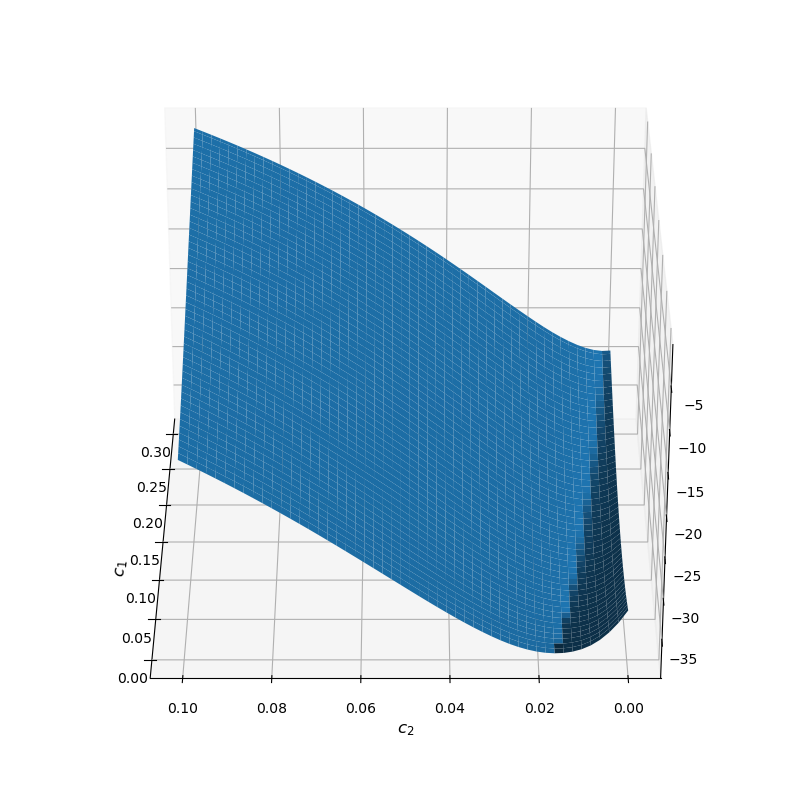

In [5]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111,projection= "3d")
ax.plot_surface(X, Y, error_map*100)
ax.view_init(30, 180)
ax.set_xlabel(r'$c_1$', fontsize=12)
ax.set_ylabel(r'$c_2$', fontsize=12)
print(f"min c1 is : {min_idx[0]}")
print(f"min c2 is : {min_idx[1]}")
print(f"Min difference is {min_error}")

Plot the control map with the resulting $c_1,c_2$.

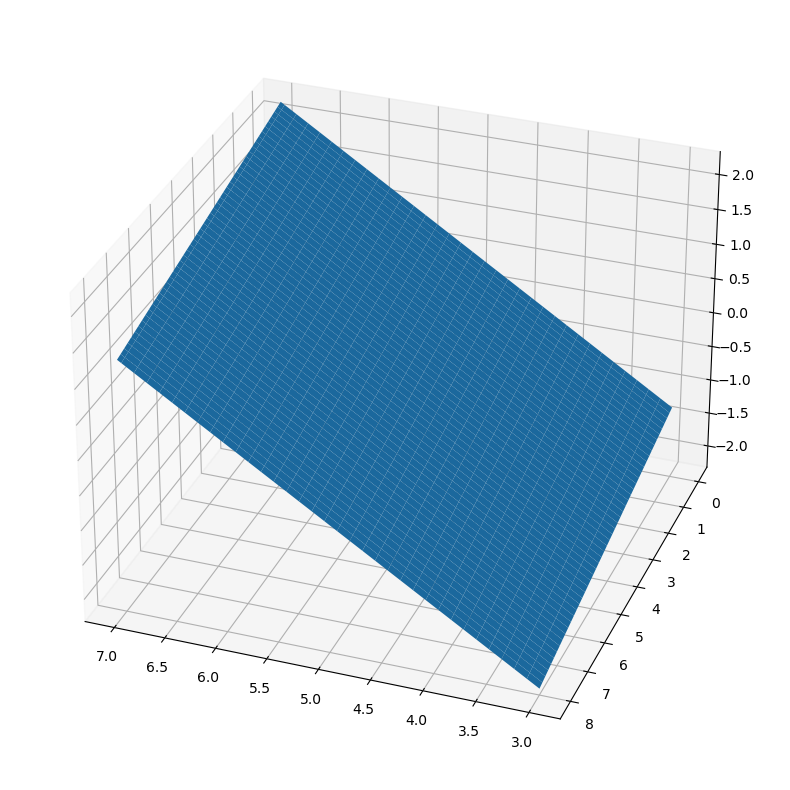

In [6]:
t = np.linspace(T,0,hybrid_solution.nstep+1)
yT=[0,0,0,10]
ode_sol = odeint(ode_value_map,y0=yT,t=t,args = (1,1,min_idx[0],min_idx[1]))
g = ode_sol[::-1,:][:,2]
h = ode_sol[::-1,:][:,3]
X_range = np.linspace(-2,2,101)
I_range = np.linspace(-4,4,50)
X,Y = np.meshgrid(X_range,I_range)
control_map = control(X,Y,g[0],h[0],min_idx[0])
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111,projection= "3d")
ax.plot_surface(X+5,Y+4,control_map)
ax.view_init(30,110)

Let us do out-of-sample analysis and see if GP does better than in-sample.

In [7]:
X_gp,I_gp,B_gp,gp_cost = hybrid_solution.monteCarlo_GPcontrol(X0=5,I0=4,N_MC=10000,init_sigma=None,randomize=False,new_sim=True)
X_lq,I_lq,B_lq,lq_cost  = exact_law(running_Bpen=min_idx[0],running_Ipen=min_idx[1],terminal_Ipen=10,new_sim=False,X_sim_input=X_gp)

In [8]:
print(f"GP cost {gp_cost}")
print(f"LQG cost {lq_cost}")
print(f"Percent difference { (lq_cost - gp_cost)/lq_cost}")

GP cost 11.524269004761923
LQG cost 8.294765815169775
Percent difference -0.38934229869225634


In [9]:
gp_cost_MC    = np.sum ( (X_gp[:,:-1]-5-B_gp)**2 *hybrid_solution.dt,axis=1) +hybrid_solution.final_cost.cost(I_gp[:,-1])
lq_cost_MC =np.sum( (X_gp[:,:-1]-5-B_lq)**2 *hybrid_solution.dt,axis=1) +hybrid_solution.final_cost.cost(I_lq[:,-1])

In [10]:
lq_cost_MC

array([ 5.48687748,  2.82547755,  1.98806508, ..., 11.09966796,
        3.34259563, 10.9473221 ])

GP cost:7.940506121227862
LQG cost:7.487240277511813


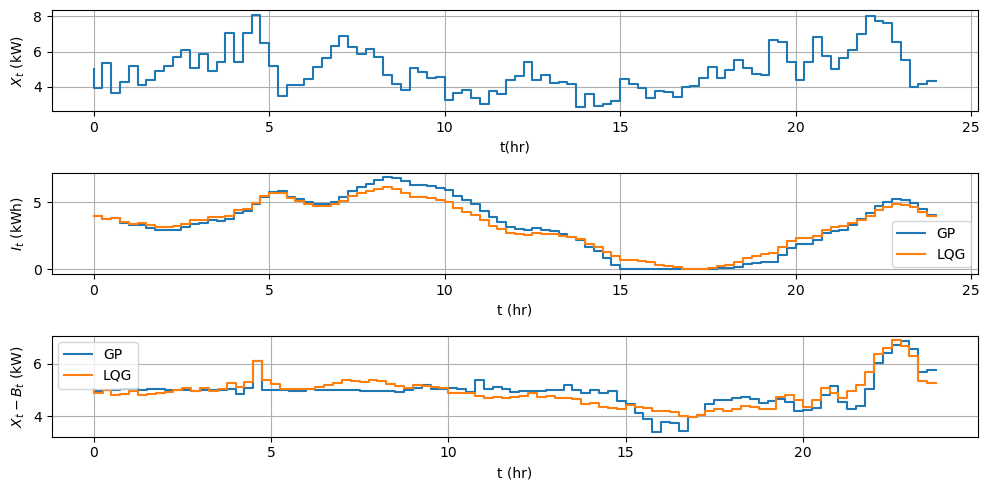

In [11]:
idx = np.random.choice(10000)

t = np.arange(0,24+.25,.25)
fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(311)
ax0.step(t,X_gp[idx,:])
ax0.grid(True)
ax0.set_xlabel(r"t(hr)")
ax0.set_ylabel(r"$X_t$ (kW)")
ax1 = fig.add_subplot(312)
ax1.step(t,I_gp[idx,:])
ax1.step(t,I_lq[idx,:])
ax1.set_xlabel("t (hr)")
ax1.set_ylabel(r"$I_t$ (kWh)")
ax1.grid(True)
ax1.legend(["GP","LQG"])
plt.tight_layout()
t = np.arange(0,24,.25)
ax2 = fig.add_subplot(313)
ax2.step(t,X_gp[idx,:-1]-B_gp[idx,:])
ax2.step(t,X_gp[idx,:-1]-B_lq[idx,:])
ax2.set_xlabel("t (hr)")
ax2.set_ylabel(r"$X_t-B_t$ (kW)")
ax2.legend(["GP","LQG"])
ax2.grid(True)
plt.tight_layout()
print(f"GP cost:{gp_cost_MC[idx]}")
print(f"LQG cost:{lq_cost_MC[idx]}")




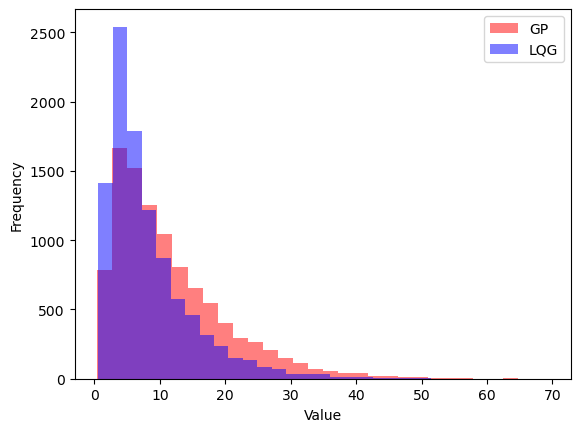

In [12]:

plt.hist(gp_cost_MC ,bins=30, alpha=0.5, color='red', label='GP')
plt.hist(lq_cost_MC, bins=30, alpha=0.5, color='blue', label='LQG')
# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
# Show plot
plt.show()


Text(0, 0.5, 'GP cost')

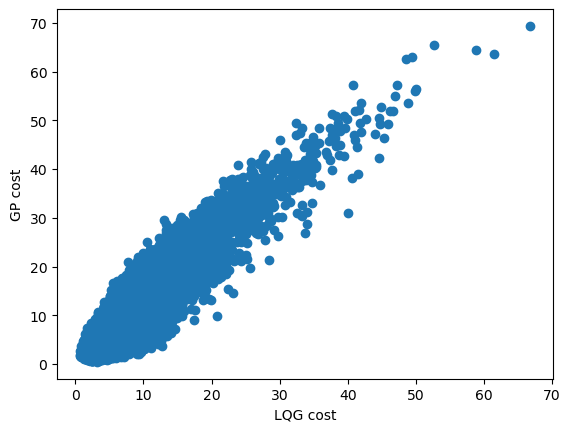

In [13]:
plt.scatter(lq_cost_MC,gp_cost_MC)
plt.xlabel("LQG cost")
plt.ylabel("GP cost")

**In addition, our exact solution has value function**. 

Let us use this value function to determine how much cost increase do we have from constraining B and I. This allows us to determine the **price** from constraint. We proceed with following procedure.

- Create a meshgrid of possible $(X_0,I_0)$
- Use the same MC scenarios and best $c_1,c_2$ value to determine $V_0(X_0,I_0)$ from unconstrained solution and $V^{cap}_0(X_0,I_0)$
- Compute $V^{cap}_0(X_0,I_0) - V_0(X_0,I_0)$
- This is similar to comparing unlimited $B,I$ vs limited $B,I$. So, the cost is for particular limit of $B,I$.



In [14]:
def exact_law(running_Bpen=1,running_Ipen=1,terminal_Ipen=10,X0 = 5,I0=4):
    hybrid_solution.process.X0 = X0
    X_sims = hybrid_solution.process.simulate(new_sim=False)
    Bts = np.zeros((X_sims.shape[0],hybrid_solution.process.nstep))
    Is = np.zeros((X_sims.shape[0],hybrid_solution.process.nstep+1)); 
    Is[:,0] = I0 *np.ones(X_sims.shape[0])
    T = hybrid_solution.t[-1]
    # solve ODE first
    t = np.linspace(T,0,hybrid_solution.nstep+1)
    yT=[0,0,0,terminal_Ipen]
    ode_sol = odeint(ode_value_map,y0=yT,t=t,args = (1.5,1,running_Bpen,running_Ipen))
    # returns ode solution, each column is a solution for one ODE from T to 0
    g = ode_sol[::-1,:][:,2]
    h = ode_sol[::-1,:][:,3]
    running_cost = np.zeros((X_sims.shape[0],hybrid_solution.process.nstep))

    for i in range(hybrid_solution.nstep):
    # sets P_4(T) = c_3, numerically compute and get P_4(t)
        LB = np.maximum(hybrid_solution.Bmin,hybrid_solution.charging_eff*(hybrid_solution.Ilb- Is[:,i])/hybrid_solution.dt)
        UB = np.minimum(hybrid_solution.Bmax,(hybrid_solution.Iub-Is[:,i])/(hybrid_solution.charging_eff*hybrid_solution.dt))
        Bts[:,i] = control(X_sims[:,i]-5,Is[:,i]-hybrid_solution.Imax/2,g[i],h[i],running_Bpen)
        Bts[:,i] = np.maximum(LB,np.minimum(Bts[:,i],UB))
        Is[:,i+1] = Is[:,i]+Bts[:,i]*(hybrid_solution.charging_eff*(Bts[:,i]>0) +1/hybrid_solution.charging_eff *(Bts[:,i]<0))*hybrid_solution.dt
        running_cost[:,i] = hybrid_solution.running_cost.cost(Bts[:,i],X_sims[:,i],hybrid_solution.targets[i],hybrid_solution.lower_targets[i],hybrid_solution.upper_targets[i])* hybrid_solution.dt
    total_cost = np.sum(running_cost,axis = 1) +hybrid_solution.final_cost.cost(Is[:,-1]).flatten()
    mean_total_cost = np.mean(total_cost)
    return X_sims,Is,Bts,mean_total_cost
def unconstrained_exact_law(running_Bpen=1,running_Ipen=1,terminal_Ipen=10,X0 = 5,I0=4):
    hybrid_solution.process.X0 = X0
    X_sims = hybrid_solution.process.simulate(new_sim=False)
    Bts = np.zeros((X_sims.shape[0],hybrid_solution.process.nstep))
    Is = np.zeros((X_sims.shape[0],hybrid_solution.process.nstep+1)); 
    Is[:,0] = I0 *np.ones(X_sims.shape[0])
    Bts = np.zeros((X_sims.shape[0],hybrid_solution.process.nstep))
    Is = np.zeros((X_sims.shape[0],hybrid_solution.process.nstep+1)); 
    Is[:,0] = 4 *np.ones(X_sims.shape[0])
    T = hybrid_solution.t[-1]
    t = np.linspace(T,0,hybrid_solution.nstep+1)
    yT=[0,0,0,terminal_Ipen]
    ode_sol = odeint(ode_value_map,y0=yT,t=t,args = (1.5,1,running_Bpen,running_Ipen))
    g = ode_sol[::-1,:][:,2]
    h = ode_sol[::-1,:][:,3]
    running_cost = np.zeros((X_sims.shape[0],hybrid_solution.process.nstep))

    for i in range(hybrid_solution.nstep):
    # sets P_4(T) = c_3, numerically compute and get P_4(t)
        Bts[:,i] = control(X_sims[:,i]-5,Is[:,i]-hybrid_solution.Imax/2,g[i],h[i],running_Bpen)
        Is[:,i+1] = Is[:,i]+Bts[:,i]*(hybrid_solution.charging_eff*(Bts[:,i]>0) +1/hybrid_solution.charging_eff *(Bts[:,i]<0))*hybrid_solution.dt
        running_cost[:,i] = hybrid_solution.running_cost.cost(Bts[:,i],X_sims[:,i],hybrid_solution.targets[i],hybrid_solution.lower_targets[i],hybrid_solution.upper_targets[i])* hybrid_solution.dt
    total_cost = np.sum(running_cost,axis = 1) +hybrid_solution.final_cost.cost(Is[:,-1]).flatten()
    mean_total_cost = np.mean(total_cost)
    return X_sims,Is,Bts,mean_total_cost


In [15]:
running_Bpen = min_idx[0];running_Ipen = min_idx[1]
X_range = np.linspace(3,7,100)
I_range = np.linspace(0,8,100)
X, Y = np.meshgrid(X_range, I_range) 
constrained_cost = np.zeros_like(X)
unconstrained_cost = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        constrained_cost[i, j] = exact_law(running_Bpen,running_Ipen,10,X[i, j], Y[i, j])[-1]
        unconstrained_cost[i, j] = unconstrained_exact_law(running_Bpen,running_Ipen,10,X[i, j], Y[i, j])[-1]

In [ ]:
# Plot the surface
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, (constrained_cost-unconstrained_cost), cmap='cool')